In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array
import pickle

from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [45]:
def AddHist_data(file, hist,isbarrel,isData=True, xsec=1, lumi=1):
    
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches =[
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]  
    
    # --Complete branches (data) 
    if isData:
        print('is Data')
 
                
    # --Complete branches (MC)
    else:
        print('is MC')
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

                
                
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        print('SingleMuon trigger')
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        print('DoubleMuon trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        print('SingleElectron trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        print('MuonEG Trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        print('DoubleEG trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        print('isMC')
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

    print('after trigger',len(arrays))    
        
    
    # --cuts
    
    # MET 
#    if isData:
#        MET_cut = (arrays.loc[:,'MET'] > 30)
#    else:
#        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
#    arrays = arrays.loc[MET_cut,:]
#    print('after MET',len(arrays))
    
    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > 15)
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
    # bjet veto
#    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
#    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
#    arrays = arrays.loc[bjet_veto_mask,:]
#    print('after bjet_veto',len(arrays))

    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
    
    mask_mediumID = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<9) | (1<<11) | (1<<13)

    # Original Photon MediumID 
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID, :]
    print('after Photon ID',len(arrays))
        
    # Photon PT
    pt_cut = (arrays.loc[:,'photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut & eta_cut ,:]
    print('after photon pt eta',len(arrays))
    
    # -- Fill hist
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:
        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight']*  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))
    
def AddHist_dataFake(file, hist,isbarrel,isData=True,xsec=1,lumi=1):
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ] 
    
    # --Complete branches (data) 
    if isData:
        print('is Data')

                
    # --Complete branches (MC)
    else:
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
    
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()
        
    
    # --cuts
#    # MET 
#    if isData:
#        MET_cut = (arrays.loc[:,'MET'] > 30)
#    else:
#        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
#    arrays = arrays.loc[MET_cut,:]

    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > 15)
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
#    # bjet veto
#    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
#    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
#    arrays = arrays.loc[bjet_veto_mask,:]
#    print('after bjet_veto',len(arrays))

    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)        
    arrays = arrays.loc[eta_cut,:]
    print("Photon eta cut: ",len(arrays))
    
    pt_cut  = (arrays.loc[:,'photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut,:]
    print("Photon pt cut: ",len(arrays))
    
    # Invert Photon MediumID 
    mask_mediumID = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<9) | (1<<11) | (1<<13)
    mask_invert_IsoChg = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<11) | (1<<13)
    mask_invert_sieie  = (1<<1) | (1<<3) | (1<<5) | (1<<9)  | (1<<11) | (1<<13)
    
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID
    
    # case I cut fail sieie or IsoChg in medium cut
    cut_fail_IsoChg = (arrays.loc[:,'mediumID'] == mask_invert_IsoChg)
    cut_fail_Sieie  = (arrays.loc[:,'mediumID'] == mask_invert_sieie)
    cut_fail_medium = cut_fail_IsoChg | cut_fail_Sieie
    
    # case II cut fail one of medium cut
    #cut_fail_medium = (arrays.loc[:,'mediumID'] != mask_mediumID)
    
    
    
    arrays = arrays.loc[cut_fail_medium, :]
    print('after not medium',len(arrays)) 
    
    
    # -- Fill hist
    
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:

        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight'] *  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))

In [46]:
## 2016 CR

filelist_data = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root"
]

In [47]:
filelist_MC = {
    
   "TTG":
        {"name":"TTGJets",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":4.078,
        },
   "TTZ":
        {"name":"TTZToLLNuNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2432,
        },
   "TTW":
        {"name":"TTWJetsToLNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":0.2149,
        },
   "tZq":
        {"name":"tZq_ll",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.07358,
        },
   "WWW":
        {"name":"WWW",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2086,
        },
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root",
        "xsec":55.48,
        },
    "ZZ":
        {"name":"ZZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root",
        "xsec":16.523, # NLO
        },
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root",
        "xsec":0.0384,
        },
   "WWZ":
        {"name":"WWZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.1707,
        },
   "ggZZ_2e2mu":
        {"name":"ggZZ2e2mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2e2nu":
#        {"name":"ggZZ2e2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2e2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2e2tau":
        {"name":"ggZZ2e2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2mu2nu":
#        {"name":"ggZZ2mu2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2mu2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2mu2tau":
        {"name":"ggZZ2mu2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
   "ggZZ_4e":
        {"name":"ggZZ4e",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4mu":
        {"name":"ggZZ4mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4tau":
        {"name":"ggZZ4tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        }    
}

In [54]:
from array import array



# Origin
xbins_EB = [20,30,50,80,120,180]
xbins_EE = [20,50,180]

# Tunning
#xbins_EB = [20,35,400]
#xbins_EE = [20,400]



isbarrel = 1 # barrel
#isbarrel = 0 # endcap


nbins=-1
if isbarrel == 1:
    xbins = xbins_EB
    nbins = len(xbins_EB) - 1
elif isbarrel ==0:
    xbins = xbins_EE
    nbins = len(xbins_EE) - 1
else:
    print("wrong!")


# --Fake template
hist_datafake = ROOT.TH1F("","",nbins,array('d',xbins))
hist_datafake.Sumw2()
# data
for file in filelist_data:
    AddHist_dataFake(file, hist_datafake,isbarrel,True)
# MC
for file in filelist_MC:
    AddHist_dataFake(filelist_MC[file]['path'], hist_datafake,isbarrel,False,filelist_MC[file]['xsec'],35.86)
    
    
# Data template
hist_data = ROOT.TH1F("","",nbins,array('d',xbins))
hist_data.Sumw2()
# data
for file in filelist_data:
    AddHist_data(file, hist_data, isbarrel)   
# MC
for file in filelist_MC:
    AddHist_data(filelist_MC[file]['path'], hist_data,isbarrel,False,filelist_MC[file]['xsec'],35.86)                    

    
    


is Data
after pt 429
after Zmass 147
Photon eta cut:  100
Photon pt cut:  100
after not medium 36
events:  36


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 36/36 [00:00<00:00, 113701.01it/s]

is Data


after pt 173
after Zmass 64
Photon eta cut:  43
Photon pt cut:  43
after not medium 18
events:  18


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 18/18 [00:00<00:00, 88404.53it/s]

is Data


after pt 332
after Zmass 121
Photon eta cut:  79
Photon pt cut:  79
after not medium 26
events:  26


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 26/26 [00:00<00:00, 97892.19it/s]

is Data


after pt 326
after Zmass 127
Photon eta cut:  83
Photon pt cut:  83
after not medium 31
events:  31


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 31/31 [00:00<00:00, 114861.68it/s]

is Data


after pt 161
after Zmass 64
Photon eta cut:  45
Photon pt cut:  45
after not medium 17
events:  17


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 17/17 [00:00<00:00, 103789.18it/s]

is Data


after pt 858
after Zmass 334
Photon eta cut:  253
Photon pt cut:  253
after not medium 93
events:  93


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 93/93 [00:00<00:00, 178195.65it/s]

is Data


after pt 869
after Zmass 356
Photon eta cut:  263
Photon pt cut:  263
after not medium 116
events:  116


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 116/116 [00:00<00:00, 192384.05it/s]

is Data


after pt 336
after Zmass 71
Photon eta cut:  39
Photon pt cut:  39
after not medium 10
events:  10


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 100%|██████████| 10/10 [00:00<00:00, 27007.75it/s]

is Data


after pt 293
after Zmass 58
Photon eta cut:  40
Photon pt cut:  40
after not medium 14
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 100%|██████████| 14/14 [00:00<00:00, 47623.89it/s]

is Data


after pt 383
after Zmass 72
Photon eta cut:  51
Photon pt cut:  51
after not medium 16
events:  16


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 16/16 [00:00<00:00, 84840.54it/s]

is Data


after pt 445
after Zmass 85
Photon eta cut:  53
Photon pt cut:  53
after not medium 17
events:  17


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 17/17 [00:00<00:00, 82241.25it/s]

is Data


after pt 373
after Zmass 68
Photon eta cut:  48
Photon pt cut:  48
after not medium 18
events:  18


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 18/18 [00:00<00:00, 47363.53it/s]

is Data


after pt 1231
after Zmass 258
Photon eta cut:  176
Photon pt cut:  176
after not medium 55
events:  55


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 55/55 [00:00<00:00, 163375.86it/s]

is Data


after pt 1232
after Zmass 255
Photon eta cut:  174
Photon pt cut:  174
after not medium 72
events:  72


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 72/72 [00:00<00:00, 92834.27it/s]

is Data


after pt 93
after Zmass 17
Photon eta cut:  9
Photon pt cut:  9
after not medium 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 100%|██████████| 6/6 [00:00<00:00, 22349.75it/s]

is Data


after pt 34
after Zmass 9
Photon eta cut:  4
Photon pt cut:  4
after not medium 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 100%|██████████| 2/2 [00:00<00:00, 18078.90it/s]

is Data


after pt 64
after Zmass 6
Photon eta cut:  4
Photon pt cut:  4
after not medium 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]

is Data


after pt 61
after Zmass 8
Photon eta cut:  4
Photon pt cut:  4
after not medium 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


after pt 40
after Zmass 7
Photon eta cut:  4
Photon pt cut:  4
after not medium 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


after pt 160
after Zmass 23
Photon eta cut:  15
Photon pt cut:  15
after not medium 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 6/6 [00:00<00:00, 33644.15it/s]

is Data


after pt 109
after Zmass 19
Photon eta cut:  13
Photon pt cut:  13
after not medium 5
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 100%|██████████| 5/5 [00:00<00:00, 16939.84it/s]

is Data


after pt 2306
after Zmass 1590
Photon eta cut:  1028
Photon pt cut:  1028
after not medium 386
events:  386


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 386/386 [00:00<00:00, 110038.83it/s]

is Data


after pt 708
after Zmass 511
Photon eta cut:  342
Photon pt cut:  342
after not medium 111
events:  111


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 111/111 [00:00<00:00, 156598.64it/s]

is Data


after pt 2041
after Zmass 1348
Photon eta cut:  899
Photon pt cut:  899
after not medium 339
events:  339


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 339/339 [00:00<00:00, 83369.63it/s]

is Data


after pt 1601
after Zmass 1100
Photon eta cut:  747
Photon pt cut:  747
after not medium 292
events:  292


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 292/292 [00:00<00:00, 195083.91it/s]

is Data


after pt 1464
after Zmass 1001
Photon eta cut:  696
Photon pt cut:  696
after not medium 235
events:  235


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 235/235 [00:00<00:00, 195956.55it/s]

is Data


after pt 5136
after Zmass 3559
Photon eta cut:  2481
Photon pt cut:  2481
after not medium 909
events:  909


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 909/909 [00:00<00:00, 113677.28it/s]

is Data


after pt 5900
after Zmass 4153
Photon eta cut:  2891
Photon pt cut:  2891
after not medium 1065
events:  1065


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 1065/1065 [00:00<00:00, 217094.37it/s]

is Data


after pt 5080
after Zmass 3169
Photon eta cut:  2120
Photon pt cut:  2120
after not medium 787
events:  787


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 787/787 [00:00<00:00, 111619.29it/s]

is Data


after pt 3351
after Zmass 2067
Photon eta cut:  1457
Photon pt cut:  1457
after not medium 511
events:  511


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 511/511 [00:00<00:00, 198728.73it/s]

is Data


after pt 5115
after Zmass 3143
Photon eta cut:  2157
Photon pt cut:  2157
after not medium 828
events:  828


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 828/828 [00:00<00:00, 216540.95it/s]

is Data


after pt 3744
after Zmass 2295
Photon eta cut:  1566
Photon pt cut:  1566
after not medium 586
events:  586


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 586/586 [00:00<00:00, 106770.73it/s]

is Data


after pt 3086
after Zmass 1906
Photon eta cut:  1322
Photon pt cut:  1322
after not medium 462
events:  462


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 462/462 [00:00<00:00, 120238.80it/s]

is Data


after pt 11963
after Zmass 7408
Photon eta cut:  5103
Photon pt cut:  5103
after not medium 1866
events:  1866


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 1866/1866 [00:00<00:00, 218857.73it/s]

is Data


after pt 13276
after Zmass 8310
Photon eta cut:  5761
Photon pt cut:  5761
after not medium 2164
events:  2164


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 2164/2164 [00:00<00:00, 110055.22it/s]


after pt 28873
after Zmass 5385
Photon eta cut:  4330
Photon pt cut:  4330
after not medium 829
events:  829


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 829/829 [00:00<00:00, 116473.32it/s]


after pt 169659
after Zmass 104376
Photon eta cut:  74202
Photon pt cut:  74202
after not medium 26672
events:  26672


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 26672/26672 [00:00<00:00, 86690.99it/s]


after pt 44803
after Zmass 8196
Photon eta cut:  5766
Photon pt cut:  5766
after not medium 1948
events:  1948


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 1948/1948 [00:00<00:00, 122755.81it/s]


after pt 128359
after Zmass 95048
Photon eta cut:  61380
Photon pt cut:  61380
after not medium 22344
events:  22344


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 22344/22344 [00:00<00:00, 108171.76it/s]


after pt 33
after Zmass 3
Photon eta cut:  1
Photon pt cut:  1
after not medium 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


after pt 3803908
after Zmass 1352562
Photon eta cut:  1042092
Photon pt cut:  1042092
after not medium 188434
events:  188434


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 188434/188434 [00:01<00:00, 99561.98it/s] 


after pt 5172
after Zmass 4053
Photon eta cut:  2714
Photon pt cut:  2714
after not medium 1037
events:  1037


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 1037/1037 [00:00<00:00, 118064.42it/s]


after pt 23772
after Zmass 8019
Photon eta cut:  6224
Photon pt cut:  6224
after not medium 1154
events:  1154


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 1154/1154 [00:00<00:00, 71130.64it/s]


after pt 444
after Zmass 264
Photon eta cut:  186
Photon pt cut:  186
after not medium 60
events:  60


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 60/60 [00:00<00:00, 92283.92it/s]


after pt 287571
after Zmass 193840
Photon eta cut:  144223
Photon pt cut:  144223
after not medium 32029
events:  32029


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 32029/32029 [00:00<00:00, 79678.11it/s]


after pt 36300
after Zmass 27480
Photon eta cut:  22540
Photon pt cut:  22540
after not medium 11999
events:  11999


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 11999/11999 [00:00<00:00, 84796.02it/s]


after pt 45990
after Zmass 38428
Photon eta cut:  31621
Photon pt cut:  31621
after not medium 17099
events:  17099


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 17099/17099 [00:00<00:00, 123852.08it/s]


after pt 448693
after Zmass 276633
Photon eta cut:  203474
Photon pt cut:  203474
after not medium 47395
events:  47395


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 47395/47395 [00:00<00:00, 124045.99it/s]


after pt 721710
after Zmass 488613
Photon eta cut:  394917
Photon pt cut:  394917
after not medium 78471
events:  78471


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 78471/78471 [00:00<00:00, 98380.16it/s] 


after pt 2581
after Zmass 384
Photon eta cut:  315
Photon pt cut:  315
after not medium 165
events:  165


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 165/165 [00:00<00:00, 87858.34it/s]

is Data


DoubleEG trigger
after trigger 2150
after pt 429
after Zmass 147
after Photon ID 45
after photon pt eta 31
events:  31


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 31/31 [00:00<00:00, 70397.09it/s]

is Data


DoubleEG trigger
after trigger 978
after pt 173
after Zmass 64
after Photon ID 17
after photon pt eta 11
events:  11


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 11/11 [00:00<00:00, 55856.35it/s]

is Data


DoubleEG trigger
after trigger 1533
after pt 332
after Zmass 121
after Photon ID 32
after photon pt eta 27
events:  27


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 27/27 [00:00<00:00, 106534.53it/s]

is Data


DoubleEG trigger
after trigger 1394
after pt 326
after Zmass 127
after Photon ID 27
after photon pt eta 19
events:  19


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 19/19 [00:00<00:00, 84240.78it/s]

is Data


DoubleEG trigger
after trigger 1194
after pt 161
after Zmass 64
after Photon ID 19
after photon pt eta 17
events:  17


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 17/17 [00:00<00:00, 79137.81it/s]

is Data


DoubleEG trigger
after trigger 3355
after pt 858
after Zmass 334
after Photon ID 93
after photon pt eta 73
events:  73


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 73/73 [00:00<00:00, 130346.61it/s]

is Data


DoubleEG trigger
after trigger 3626
after pt 869
after Zmass 356
after Photon ID 85
after photon pt eta 63
events:  63


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 63/63 [00:00<00:00, 153807.42it/s]

is Data


DoubleMuon trigger
after trigger 1617
after pt 336
after Zmass 71
after Photon ID 21
after photon pt eta 13
events:  13


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 100%|██████████| 13/13 [00:00<00:00, 71182.70it/s]

is Data


DoubleMuon trigger
after trigger 708
after pt 293
after Zmass 58
after Photon ID 21
after photon pt eta 17
events:  17


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 100%|██████████| 17/17 [00:00<00:00, 54305.54it/s]

is Data


DoubleMuon trigger
after trigger 1145
after pt 383
after Zmass 72
after Photon ID 19
after photon pt eta 15
events:  15


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 15/15 [00:00<00:00, 79638.68it/s]

is Data


DoubleMuon trigger
after trigger 1120
after pt 445
after Zmass 85
after Photon ID 26
after photon pt eta 14
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 14/14 [00:00<00:00, 43658.18it/s]

is Data


DoubleMuon trigger
after trigger 912
after pt 373
after Zmass 68
after Photon ID 14
after photon pt eta 12
events:  12


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 12/12 [00:00<00:00, 42473.96it/s]

is Data


DoubleMuon trigger
after trigger 2478
after pt 1231
after Zmass 258
after Photon ID 63
after photon pt eta 44
events:  44


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 44/44 [00:00<00:00, 130793.32it/s]

is Data


DoubleMuon trigger
after trigger 2712
after pt 1232
after Zmass 255
after Photon ID 62
after photon pt eta 44
events:  44


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 44/44 [00:00<00:00, 63245.16it/s]

is Data


MuonEG Trigger
after trigger 181
after pt 93
after Zmass 17
after Photon ID 4
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 100%|██████████| 1/1 [00:00<00:00, 8035.07it/s]

is Data


MuonEG Trigger
after trigger 76
after pt 34
after Zmass 9
after Photon ID 1
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]

is Data


MuonEG Trigger
after trigger 126
after pt 64
after Zmass 6
after Photon ID 3
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 100%|██████████| 2/2 [00:00<00:00, 8136.38it/s]

is Data


MuonEG Trigger
after trigger 133
after pt 61
after Zmass 8
after Photon ID 3
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 100%|██████████| 2/2 [00:00<00:00, 11983.73it/s]

is Data


MuonEG Trigger
after trigger 114
after pt 40
after Zmass 7
after Photon ID 3
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 100%|██████████| 1/1 [00:00<00:00, 4092.00it/s]

is Data


MuonEG Trigger
after trigger 280
after pt 160
after Zmass 23
after Photon ID 7
after photon pt eta 5
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 5/5 [00:00<00:00, 30705.01it/s]

is Data


MuonEG Trigger
after trigger 276
after pt 109
after Zmass 19
after Photon ID 7
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 100%|██████████| 6/6 [00:00<00:00, 23541.46it/s]

is Data


SingleElectron trigger
after trigger 17501
after pt 2306
after Zmass 1590
after Photon ID 425
after photon pt eta 311
events:  311


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 311/311 [00:00<00:00, 156293.86it/s]

is Data


SingleElectron trigger
after trigger 7197
after pt 708
after Zmass 511
after Photon ID 126
after photon pt eta 89
events:  89


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 89/89 [00:00<00:00, 166500.02it/s]

is Data


SingleElectron trigger
after trigger 12090
after pt 2041
after Zmass 1348
after Photon ID 330
after photon pt eta 233
events:  233


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 233/233 [00:00<00:00, 195415.48it/s]

is Data


SingleElectron trigger
after trigger 10390
after pt 1601
after Zmass 1100
after Photon ID 250
after photon pt eta 183
events:  183


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 183/183 [00:00<00:00, 187117.90it/s]

is Data


SingleElectron trigger
after trigger 8234
after pt 1464
after Zmass 1001
after Photon ID 270
after photon pt eta 217
events:  217


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 217/217 [00:00<00:00, 181415.98it/s]

is Data


SingleElectron trigger
after trigger 23451
after pt 5136
after Zmass 3559
after Photon ID 801
after photon pt eta 604
events:  604


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 604/604 [00:00<00:00, 196323.59it/s]

is Data


SingleElectron trigger
after trigger 26053
after pt 5900
after Zmass 4153
after Photon ID 901
after photon pt eta 671
events:  671


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 671/671 [00:00<00:00, 211543.75it/s]

is Data


SingleMuon trigger
after trigger 26828
after pt 5080
after Zmass 3169
after Photon ID 844
after photon pt eta 623
events:  623


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 623/623 [00:00<00:00, 219068.69it/s]

is Data


SingleMuon trigger
after trigger 12592
after pt 3351
after Zmass 2067
after Photon ID 536
after photon pt eta 412
events:  412


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 412/412 [00:00<00:00, 125030.99it/s]

is Data


SingleMuon trigger
after trigger 20697
after pt 5115
after Zmass 3143
after Photon ID 805
after photon pt eta 602
events:  602


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 602/602 [00:00<00:00, 220656.38it/s]

is Data


SingleMuon trigger
after trigger 18656
after pt 3744
after Zmass 2295
after Photon ID 573
after photon pt eta 434
events:  434


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 434/434 [00:00<00:00, 201030.14it/s]

is Data


SingleMuon trigger
after trigger 14784
after pt 3086
after Zmass 1906
after Photon ID 506
after photon pt eta 375
events:  375


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 375/375 [00:00<00:00, 192847.47it/s]

is Data


SingleMuon trigger
after trigger 40818
after pt 11963
after Zmass 7408
after Photon ID 1705
after photon pt eta 1285
events:  1285


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 1285/1285 [00:00<00:00, 221606.05it/s]

is Data


SingleMuon trigger
after trigger 47810
after pt 13276
after Zmass 8310
after Photon ID 1924
after photon pt eta 1428
events:  1428


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 1428/1428 [00:00<00:00, 213695.81it/s]

is MC


isMC
after trigger 32620
after pt 28873
after Zmass 5385
after Photon ID 4069
after photon pt eta 3357
events:  3357


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 3357/3357 [00:00<00:00, 122312.76it/s]

is MC


isMC
after trigger 170133
after pt 169659
after Zmass 104376
after Photon ID 22131
after photon pt eta 17120
events:  17120


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 17120/17120 [00:00<00:00, 94489.92it/s]

is MC


isMC
after trigger 45760
after pt 44803
after Zmass 8196
after Photon ID 2125
after photon pt eta 1639
events:  1639


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 1639/1639 [00:00<00:00, 122808.73it/s]

is MC


isMC
after trigger 129340
after pt 128359
after Zmass 95048
after Photon ID 17679
after photon pt eta 13027
events:  13027


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 13027/13027 [00:00<00:00, 80800.80it/s]


is MC
isMC
after trigger 148
after pt 33
after Zmass 3
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]

is MC


isMC
after trigger 3877650
after pt 3803908
after Zmass 1352562
after Photon ID 1071862
after photon pt eta 835660
events:  835660


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 835660/835660 [00:06<00:00, 121542.10it/s]


is MC
isMC
after trigger 5896
after pt 5172
after Zmass 4053
after Photon ID 970
after photon pt eta 678
events:  678


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 678/678 [00:00<00:00, 109475.60it/s]

is MC


isMC
after trigger 23791
after pt 23772
after Zmass 8019
after Photon ID 6361
after photon pt eta 4971
events:  4971


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 4971/4971 [00:00<00:00, 124104.24it/s]

is MC


isMC
after trigger 572
after pt 444
after Zmass 264
after Photon ID 84
after photon pt eta 63
events:  63


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 63/63 [00:00<00:00, 89060.04it/s]

is MC


isMC
after trigger 287912
after pt 287571
after Zmass 193840
after Photon ID 138475
after photon pt eta 105893
events:  105893


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 105893/105893 [00:00<00:00, 110677.60it/s]


is MC
isMC
after trigger 36880
after pt 36300
after Zmass 27480
after Photon ID 6598
after photon pt eta 5208
events:  5208


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 5208/5208 [00:00<00:00, 71812.29it/s]

is MC


isMC
after trigger 46554
after pt 45990
after Zmass 38428
after Photon ID 8675
after photon pt eta 6836
events:  6836


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 6836/6836 [00:00<00:00, 94151.58it/s]

is MC


isMC
after trigger 448806
after pt 448693
after Zmass 276633
after Photon ID 198884
after photon pt eta 148853
events:  148853


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 148853/148853 [00:01<00:00, 101710.60it/s]


is MC
isMC
after trigger 723069
after pt 721710
after Zmass 488613
after Photon ID 347138
after photon pt eta 296366
events:  296366


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 296366/296366 [00:02<00:00, 117571.13it/s]


is MC
isMC
after trigger 3672
after pt 2581
after Zmass 384
after Photon ID 93
after photon pt eta 73
events:  73


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 73/73 [00:00<00:00, 79839.42it/s]


35.86 fb^{-1} (13 TeV)


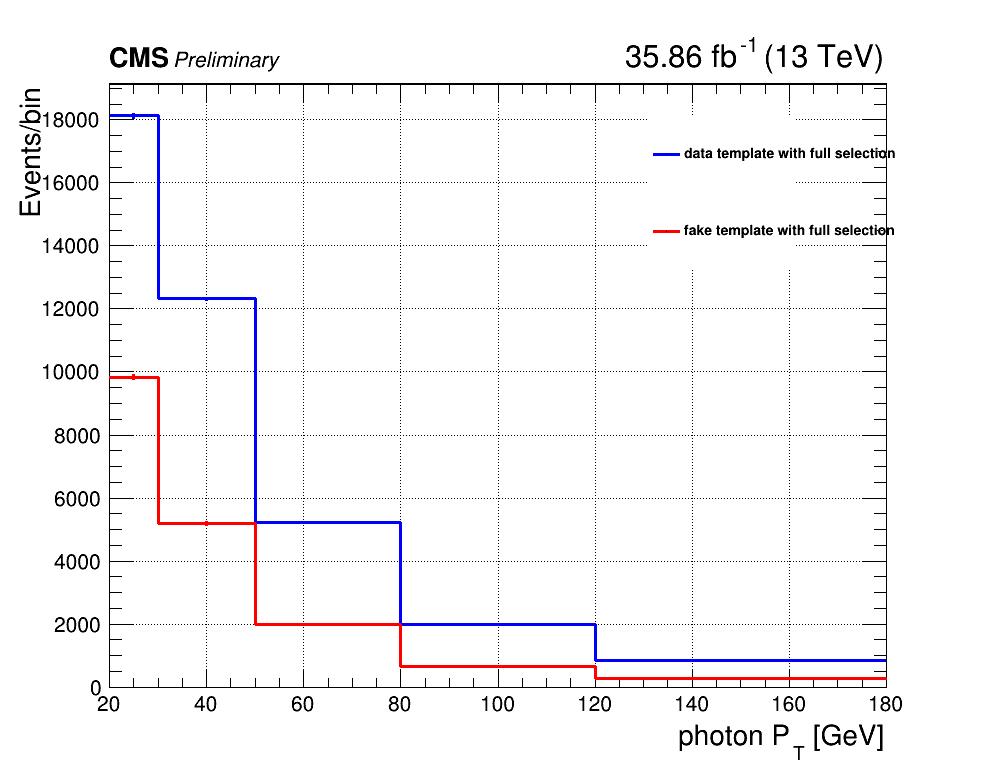

In [55]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()

hist_data.GetXaxis().SetTitle("photon P_{T} [GeV]")
hist_data.GetYaxis().SetTitle("Events/bin")
hist_data.SetMarkerStyle(0)
hist_data.SetLineColor(4)
hist_data.SetLineWidth(3)
hist_data.Draw("HIST e")



hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HIST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template with full selection')
legend.AddEntry(hist_datafake,'fake template with full selection')
legend.Draw("SAME")




#ROOT.gPad.SetLogx()
ROOT.gPad.SetGrid()

CMS_lumi(c1,0,0)

### Calculate FakeWeight

In [51]:
file1 = ROOT.TFile("DataTemplate_EE_data.root","recreate")
file1.cd()
hist_data.Write()
file1.Close()

file2 = ROOT.TFile("FakeTemplate_EE_fake.root","recreate")
file2.cd()
hist_datafake.Write()
file2.Close()

!ls

2016				    images
2017				    log.csv
2018				    Lumi.py
a				    MagicDraw
Combined_plot_2016.ipynb	    Merged_file
Combined_plot_FakeLepton2016.ipynb  Merged_file_211028
Combined_plot.ipynb		    Merged_file_FakePhoton_211128
Combined_plot_SR2016.ipynb	    Mu_Fake_Rate_2D_2016.root
Combined_plot_ZZ2016.ipynb	    npy_dict
DataTemplate_EB_data.root	    pickle_dict
DataTemplate_EE_data.root	    pickle_dict_sample
Electron_channel		    __pycache__
Ele_Fake_Rate_2D_2016.root	    Ratio_Plot.py
fakefraction_real.csv		    results_2016
FakeLepton2016_Ele.ipynb	    Scale_PDF_Unc.ipynb
FakeLepton2016_Mu.ipynb		    TDR_Style.py
FakeLepton2017_Ele.ipynb	    Template_Fit_2016.ipynb
FakeLepton2018_Ele.ipynb	    Template_Fit_AR_2017.ipynb
FakeLepton_SingleEle_check.ipynb    Template_Fit_AR_2018.ipynb
FakePhoton_2017-2018_hist_ref	    Template_Fit.ipynb
FakeTemplate_EB_fake.root	    Test_Fit.ipynb
FakeTemplate_EE_fake.root	    WZG_sample
FakeWeight_2016.ipynb		    Yeop_test.ipynb


In [56]:
fake_fraction_2016 = {"Barrel":[0.293,0.228,0.233,0.175,0.152],
                    "Endcap":[0.434,0.29]}

In [57]:
for i in range(1,hist_data.GetNbinsX()+1):
    
    ydata= hist_data.GetBinContent(i)
    yfake= hist_datafake.GetBinContent(i)
    
    j = i-1
    
    
    if isbarrel == 1:
        print('isbarrel')
        fake_fraction = fake_fraction_2016['Barrel'][j]
    elif isbarrel ==0:
        print('isEndcap')
        fake_fraction = fake_fraction_2016['Endcap'][j]
    
    
    if (ydata == 0) or (yfake == 0):
        ratio = 0
    else:
        ratio = ydata / yfake
    
    fake_weight = ratio * fake_fraction
    print("{0}th  ydata: {1} yfake:  {2} ydata/yfake: {3:.2f} fake fraction: {4} fake weight: {5:.2f}".format(i,ydata,yfake,ratio,fake_fraction,fake_weight))

isbarrel
1th  ydata: 18128.224609375 yfake:  9829.8212890625 ydata/yfake: 1.84 fake fraction: 0.293 fake weight: 0.54
isbarrel
2th  ydata: 12317.978515625 yfake:  5184.7978515625 ydata/yfake: 2.38 fake fraction: 0.228 fake weight: 0.54
isbarrel
3th  ydata: 5230.4169921875 yfake:  1972.9248046875 ydata/yfake: 2.65 fake fraction: 0.233 fake weight: 0.62
isbarrel
4th  ydata: 1994.433837890625 yfake:  646.0548095703125 ydata/yfake: 3.09 fake fraction: 0.175 fake weight: 0.54
isbarrel
5th  ydata: 834.6087036132812 yfake:  268.48626708984375 ydata/yfake: 3.11 fake fraction: 0.152 fake weight: 0.47


---

---